In [83]:
!pip install pulp

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import pulp
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

class SchoolMealDeliveryOptimizer:
    def __init__(self, grid_size=15, num_points=20, num_vehicles=9, vehicle_capacity=30, delivery_time_limit=120 * 2, p = 0.0, speed = 40, vehicle_cost = 15):
        self.grid_size = grid_size
        self.num_points = num_points
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.delivery_time_limit = delivery_time_limit
        self.locations = None
        self.w_i = None
        self.d_ij = None
        self.t_ij = None
        self.g_ij = None
        self.p = p
        self.speed = speed #km/h
        self.vehicle_cost = vehicle_cost

    def generate_data(self):
        np.random.seed(None)  # Resetting seed
        self.locations = np.random.rand(self.num_points, 2) * self.grid_size
        self.w_i = np.maximum(np.random.normal(10, 2, self.num_points), 0)
        self.w_i[0] = 0  # Setting depot weight to 0

        # Compute distances and times
        self.d_ij = np.zeros((self.num_points, self.num_points))
        self.t_ij = np.zeros((self.num_points, self.num_points))
        for i in range(self.num_points):
            for j in range(self.num_points):
                self.d_ij[i][j] = np.linalg.norm(self.locations[i] - self.locations[j])
                self.t_ij[i][j] = self.d_ij[i][j] / self.speed * 60  # Convert to time in minutes

        self.g_ij = np.random.normal(0, 2, (self.num_points, self.num_points))

    def plot_delivery_points(self, filename='deliverry_points.png'):
      # Calculating averages and standard deviations
      avg_distance = np.mean(self.d_ij[np.triu_indices(self.num_points, k=1)])
      std_distance = np.std(self.d_ij[np.triu_indices(self.num_points, k=1)])
      avg_time = np.mean(self.t_ij[np.triu_indices(self.num_points, k=1)])
      std_time = np.std(self.t_ij[np.triu_indices(self.num_points, k=1)])
      avg_gradient = np.mean(self.g_ij[np.triu_indices(self.num_points, k=1)])
      std_gradient = np.std(self.g_ij[np.triu_indices(self.num_points, k=1)])

      # Plotting the delivery points and depot
      fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

      # Plotting Delivery Points and Depot
      scatter = ax[0, 0].scatter(self.locations[1:, 0], self.locations[1:, 1], c=self.w_i[1:], cmap='Blues', s=100 * self.w_i[1:], alpha=0.6, marker='o', edgecolors='black')
      ax[0, 0].scatter(self.locations[0, 0], self.locations[0, 1], c='red', s=250, marker='*', edgecolors='black', zorder=5)
      for i, coord in enumerate(self.locations):
          ax[0, 0].annotate(str(i), (coord[0], coord[1]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)
      ax[0, 0].set_xlabel('X-coordinate')
      ax[0, 0].set_ylabel('Y-coordinate')
      ax[0, 0].set_title('Delivery Points and Depot with Size Based on w_i')
      ax[0, 0].grid(True)
      ax[0, 0].set_xlim(0, self.grid_size)
      ax[0, 0].set_ylim(0, self.grid_size)

      # Distance Histogram
      ax[0, 1].hist(self.d_ij[np.triu_indices(self.num_points, k=1)], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
      ax[0, 1].set_title(f'Histogram of Distances\nMean: {avg_distance:.2f} km, Std: {std_distance:.2f} km')
      ax[0, 1].set_xlabel('Distance (km)')
      ax[0, 1].set_ylabel('Frequency')
      ax[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

      # Travel Time Histogram
      ax[1, 0].hist(self.t_ij[np.triu_indices(self.num_points, k=1)], bins=20, color='salmon', edgecolor='black', alpha=0.7)
      ax[1, 0].set_title(f'Histogram of Travel Times\nMean: {avg_time:.2f} mins, Std: {std_time:.2f} mins')
      ax[1, 0].set_xlabel('Travel Time (minutes)')
      ax[1, 0].set_ylabel('Frequency')
      ax[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5)

      # Gradient Histogram
      ax[1, 1].hist(self.g_ij[np.triu_indices(self.num_points, k=1)], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
      ax[1, 1].set_title(f'Histogram of Gradients\nMean: {avg_gradient:.2f}, Std: {std_gradient:.2f}')
      ax[1, 1].set_xlabel('Gradient')
      ax[1, 1].set_ylabel('Frequency')
      ax[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

      plt.tight_layout()
      plt.show()

    def dataframe_and_save(self, filename_prefix):
        # w_i to DataFrame and save
        df_wi = pd.DataFrame(self.w_i, columns=['w_i'])
        print("\nWeights (w_i):")
        print(df_wi)
#        df_wi.to_csv(f"{filename_prefix}_wi.csv", index=False)

        # d_ij to DataFrame and save
        df_dij = pd.DataFrame(self.d_ij, columns=[f"Point_{j}" for j in range(self.num_points)])
        print("\nDistances (d_ij):")
        print(df_dij)
#        df_dij.to_csv(f"{filename_prefix}_dij.csv", index=False)

        # t_ij to DataFrame and save
        df_tij = pd.DataFrame(self.t_ij, columns=[f"Point_{j}" for j in range(self.num_points)])
        print("\nTravel Times (t_ij):")
        print(df_tij)
#        df_tij.to_csv(f"{filename_prefix}_tij.csv", index=False)

        # g_ij to DataFrame and save
        df_gij = pd.DataFrame(self.g_ij, columns=[f"Point_{j}" for j in range(self.num_points)])
        print("\nGradients (g_ij):")
        print(df_gij)
#        df_gij.to_csv(f"{filename_prefix}_gij.csv", index=False)

    def optimize(self):
        model = pulp.LpProblem("SchoolMealDelivery", pulp.LpMinimize)
        x = pulp.LpVariable.dicts("x", (range(self.num_points), range(self.num_points), range(self.num_vehicles)), cat='Binary')
        model += pulp.lpSum(self.d_ij[i][j] * x[i][j][q] * (1 + self.g_ij[i][j] * self.p)
                            for i in range(self.num_points)
                            for j in range(self.num_points)
                            for q in range(self.num_vehicles))
        for q in range(self.num_vehicles):
            for i in range(self.num_points):
                model += pulp.lpSum(self.w_i[j] * x[i][j][q] for j in range(self.num_points)) <= self.vehicle_capacity
            model += pulp.lpSum(self.t_ij[i][j] * x[i][j][q] for i in range(self.num_points) for j in range(self.num_points)) <= self.delivery_time_limit
        for j in range(1, self.num_points):
            model += pulp.lpSum(x[i][j][q] for i in range(self.num_points) for q in range(self.num_vehicles)) == 1
        for i in range(1, self.num_points):
            model += pulp.lpSum(x[i][j][q] for j in range(self.num_points) for q in range(self.num_vehicles)) == 1
        for q in range(self.num_vehicles):
            model += pulp.lpSum(x[0][j][q] for j in range(1, self.num_points)) == 1
            model += pulp.lpSum(x[i][0][q] for i in range(1, self.num_points)) == 1
        model.solve()
        self.model = model
        self.x = x



    def display_results(self, filename="optimized_routes.png"):
        print(f"Optimal Objective Value: {self.model.objective.value()}")
        for q in range(self.num_vehicles):
            #route = [i for i in range(self.num_points) for j in range(self.num_points) if self.x[i][j][q].varValue > 0.5]
            route = [i for i in range(self.num_points) for j in range(self.num_points) if self.x[i][j][q].varValue is not None and self.x[i][j][q].varValue > 0.5]
            print(f"Vehicle {q} Route: {route}")

        # Plot the routes
        plt.figure(figsize=(8, 8))
        for q in range(self.num_vehicles):
            for i in range(self.num_points):
                for j in range(self.num_points):
                    #if self.x[i][j][q].varValue > 0.5:
                    if self.x[i][j][q].varValue is not None and self.x[i][j][q].varValue > 0.5:
                        plt.plot([self.locations[i][0], self.locations[j][0]],
                                 [self.locations[i][1], self.locations[j][1]], marker='o')
        plt.xlim(0, self.grid_size)
        plt.ylim(0, self.grid_size)
        plt.title("Optimized Delivery Routes")
        plt.xlabel("X-coordinate")
        plt.ylabel("Y-coordinate")
        plt.grid(True)
        #plt.savefig(filename, format='png')
        plt.show()


    def display_results_modified(self, optimizer, filename="optimized_routes.png"):
        print(f"Optimal Objective Value: {optimizer.model.objective.value()}\n")

        total_distance_travelled = 0
        total_time_taken = 0
        total_gradient = 0

        schedules = []

        colors = list(mcolors.TABLEAU_COLORS.values())  # Use tableau colors for distinction

        plt.figure(figsize=(8, 8))
        legend_patches = []  # To store legend entries

        for q in range(optimizer.num_vehicles):
            route = [i for i in range(optimizer.num_points) for j in range(optimizer.num_points) if optimizer.x[i][j][q].varValue is not None and optimizer.x[i][j][q].varValue > 0.5]

            # Ensure that the route returns to the depot
            if route[-1] != 0:
                route.append(0)

            route_distance = sum(optimizer.d_ij[route[i]][route[i+1]] for i in range(len(route)-1))
            route_time = sum(optimizer.t_ij[route[i]][route[i+1]] for i in range(len(route)-1))
            route_gradient = sum(optimizer.g_ij[route[i]][route[i+1]] for i in range(len(route)-1))

            total_distance_travelled += route_distance
            total_time_taken += route_time
            total_gradient += route_gradient

            print(f"Vehicle {q}")
            print(f"Route: {route}")
            print(f"Total Distance Travelled: {route_distance:.2f} km")
            print(f"Total Time Taken: {route_time:.2f} mins")
            print(f"Total Gradient: {route_gradient:.2f}\n")

            # Plot the routes with distinct colors
            color = colors[q % len(colors)]
            for i in range(len(route)-1):  # Iterate over the entire route
                plt.plot([optimizer.locations[route[i]][0], optimizer.locations[route[i+1]][0]],
                        [optimizer.locations[route[i]][1], optimizer.locations[route[i+1]][1]], marker='o', color=color)

            # Gantt chart scheduling
            schedule = []
            start_time = 0
            for i in range(len(route)-1):
                end_time = start_time + optimizer.t_ij[route[i]][route[i+1]]
                schedule.append((start_time, end_time - start_time, colors[route[i+1] % len(colors)]))  # Store color as well
                start_time = end_time
            schedules.append(schedule)

            # Create legend entry for this vehicle
            legend_patches.append(mpatches.Patch(color=color, label=f"Vehicle {q}"))

        # Plot legend
        plt.legend(handles=legend_patches, loc='upper left')

        plt.xlim(0, optimizer.grid_size)
        plt.ylim(0, optimizer.grid_size)
        plt.title("Optimized Delivery Routes")
        plt.xlabel("X-coordinate")
        plt.ylabel("Y-coordinate")
        plt.grid(True)
        plt.savefig(filename, format='png')
        plt.show()

        print(f"Overall Total Distance Travelled by all Vehicles: {total_distance_travelled:.2f} km")
        print(f"Overall Total Time Taken by all Vehicles: {total_time_taken:.2f} mins")
        print(f"Overall Total Gradient faced by all Vehicles: {total_gradient:.2f}")

        # Gantt chart
        fig, gnt = plt.subplots(figsize=(10, 6))
        gnt.set_ylim(0, optimizer.num_vehicles * 10)
        gnt.set_xlim(0, max(schedule[-1][0] + schedule[-1][1] for schedule in schedules) + 10)
        gnt.set_xlabel('Minutes since start')
        gnt.set_ylabel('Vehicle')
        gnt.set_yticks([5 + 10 * q for q in range(optimizer.num_vehicles)])
        gnt.set_yticklabels(['Vehicle ' + str(q) for q in range(optimizer.num_vehicles)])
        gnt.grid(True)

        for q, schedule in enumerate(schedules):
            for event in schedule:
                gnt.broken_barh([(event[0], event[1])], (10 * q, 9), facecolors=event[2])

        plt.title("Gantt Chart of Vehicle Schedules")
        plt.tight_layout()
        plt.show()



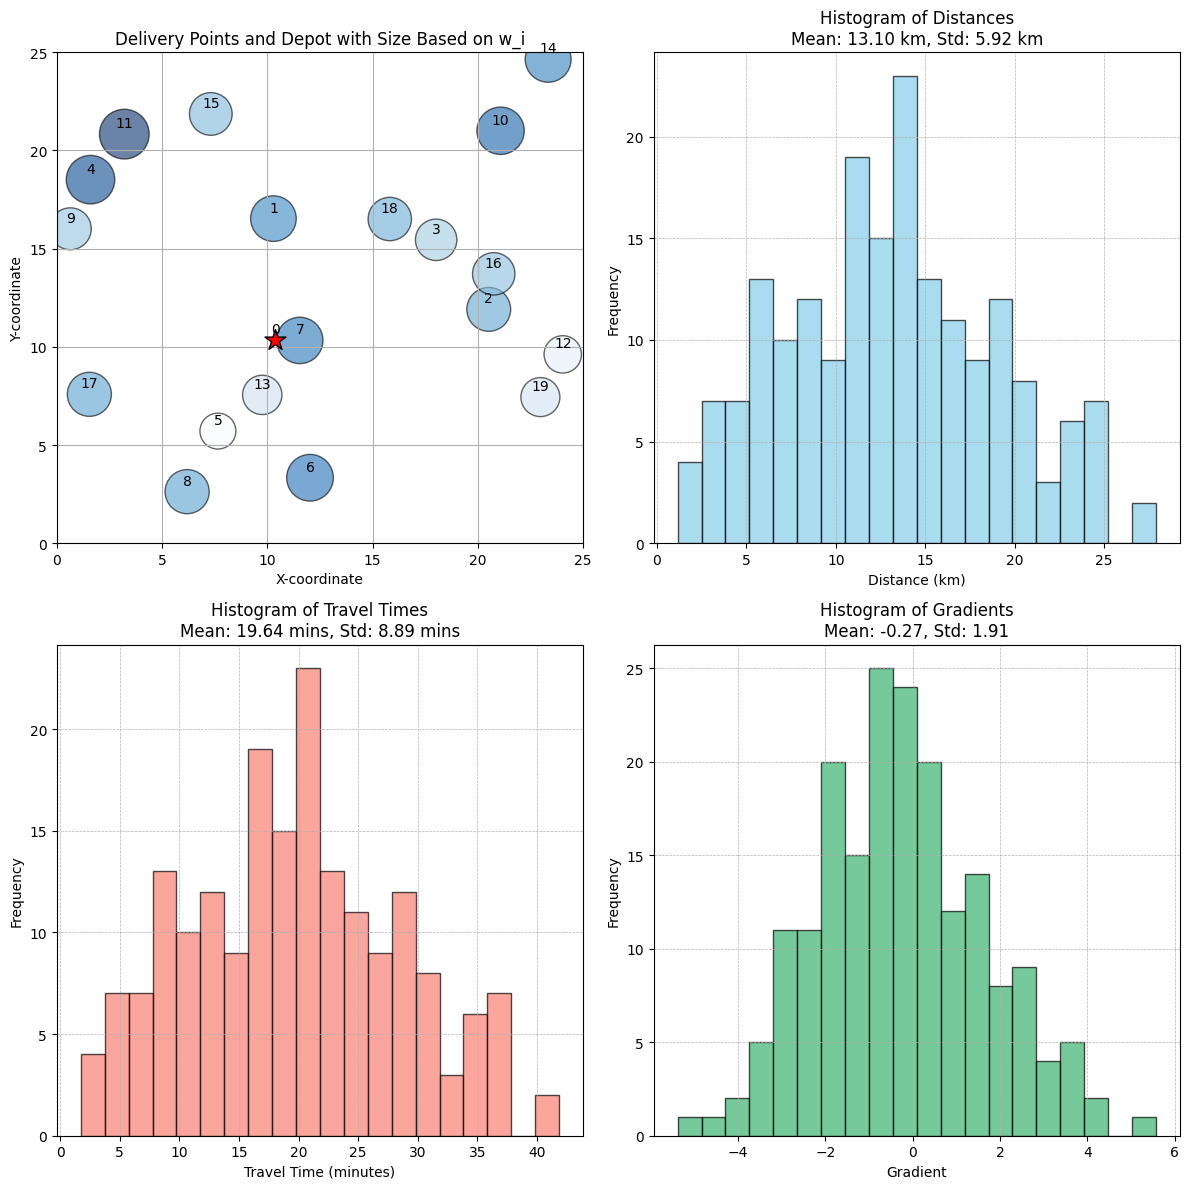


Weights (w_i):
          w_i
0    0.000000
1   10.796760
2    9.974404
3    8.905655
4   12.201954
5    6.680537
6   11.306010
7   11.175170
8   10.094313
9    9.126496
10  11.654462
11  12.812509
12   7.239623
13   8.016909
14  10.923106
15   9.459496
16   9.335538
17  10.086274
18   9.754672
19   7.888796

Distances (d_ij):
      Point_0    Point_1    Point_2    Point_3    Point_4    Point_5  \
0    0.000000   6.185273  10.252413   9.182812  11.997483   5.381455   
1    6.185273   0.000000  11.226000   7.806846   8.914064  11.135292   
2   10.252413  11.226000   0.000000   4.333931  20.040725  14.283416   
3    9.182812   7.806846   4.333931   0.000000  16.705739  14.225546   
4   11.997483   8.914064  20.040725  16.705739   0.000000  14.159026   
5    5.381455  11.135292  14.283416  14.225546  14.159026   0.000000   
6    7.197225  13.306380  12.065856  13.513798  18.412742   4.979151   
7    1.153478   6.327272   9.117320   8.260009  12.877656   6.036410   
8    8.783682  14.49210

In [145]:
optimizer = SchoolMealDeliveryOptimizer(grid_size=25)
optimizer.generate_data()
optimizer.plot_delivery_points()
optimizer.dataframe_and_save('SchoolMealDelivery')

Optimal Objective Value: 116.44578548029719

Vehicle 0
Route: [0, 4, 18, 0]
Total Distance Travelled: 34.57 km
Total Time Taken: 51.86 mins
Total Gradient: -3.57

Vehicle 1
Route: [0, 7, 12, 0]
Total Distance Travelled: 27.34 km
Total Time Taken: 41.01 mins
Total Gradient: 1.38

Vehicle 2
Route: [0, 6, 9, 0]
Total Distance Travelled: 35.51 km
Total Time Taken: 53.27 mins
Total Gradient: -4.28

Vehicle 3
Route: [0, 8, 11, 16, 0]
Total Distance Travelled: 57.07 km
Total Time Taken: 85.61 mins
Total Gradient: 1.62

Vehicle 4
Route: [0, 1, 14, 0]
Total Distance Travelled: 40.84 km
Total Time Taken: 61.26 mins
Total Gradient: 0.30

Vehicle 5
Route: [0, 2, 3, 10, 0]
Total Distance Travelled: 36.03 km
Total Time Taken: 54.04 mins
Total Gradient: 5.37

Vehicle 6
Route: [0, 13, 0]
Total Distance Travelled: 5.72 km
Total Time Taken: 8.58 mins
Total Gradient: 1.25

Vehicle 7
Route: [0, 15, 17, 19, 0]
Total Distance Travelled: 61.66 km
Total Time Taken: 92.49 mins
Total Gradient: -8.27

Vehicle 8


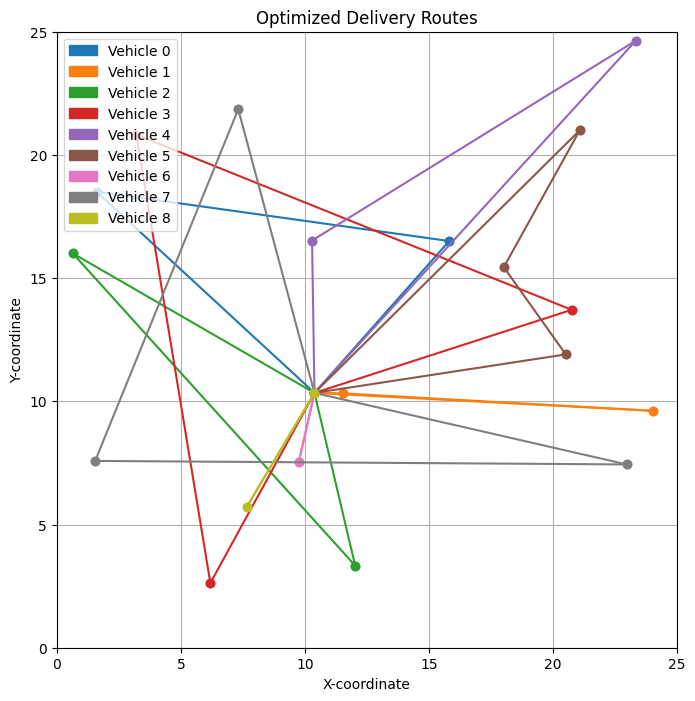

Overall Total Distance Travelled by all Vehicles: 309.50 km
Overall Total Time Taken by all Vehicles: 464.26 mins
Overall Total Gradient faced by all Vehicles: -10.83


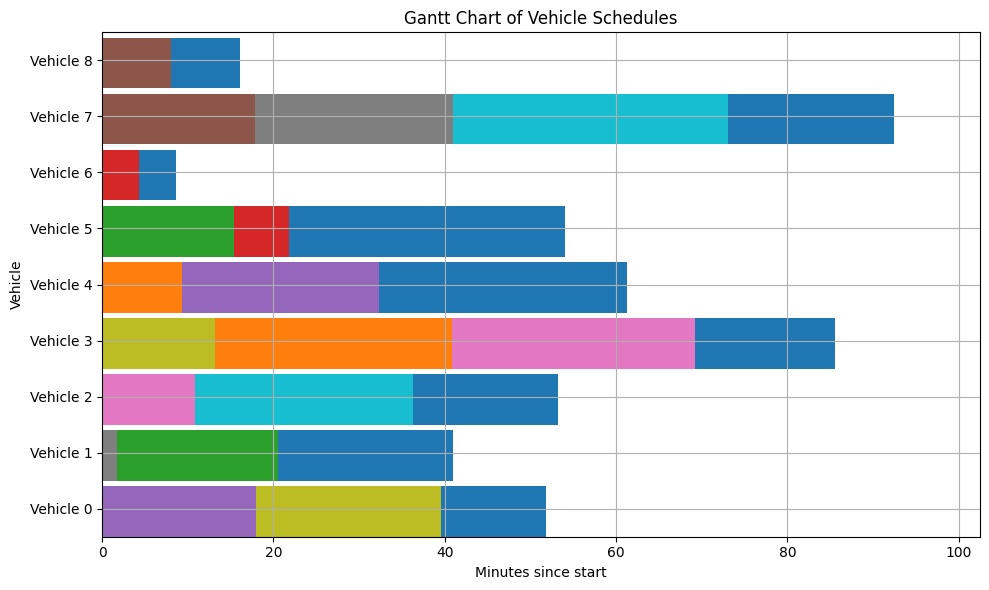

In [146]:
optimizer.optimize() # Commented out as we can't run pulp here.
optimizer.display_results_modified(optimizer)